## Машинное обучение для прогнозирования S&P 500 и DJIA по макроэкономическим данным

---
**Исследовательские вопросы**


1. Какие макроэкономические показатели оказывают наибольшее влияние на динамику фондовых индексов США: S&P 500 и DJIA(Dow Jones Industrial Average) в период с 1992 по 2024 год?

2. Насколько эффективно методы машинного обучения (линейная регрессия, случайный лес, нейронные сети) способны прогнозировать значения S&P 500 и DJIA на основе макроэкономических данных по сравнению с классическими временными моделями (ARIMA)?

3. Какая из рассмотренных моделей (линейная регрессия, случайный лес, нейронные сети, ARIMA) обеспечивает наилучшую точность прогнозирования фондовых индексов на тестовой выборке, и какие макроэкономические переменные оказываются наиболее значимыми для этих моделей?


### **Источник данных и описание**

Данные по макроэкономическим переменным были взяты из набора данных OECD: [ссылка](https://data-explorer.oecd.org/vis?lc=en&fs[0]=Topic%2C1%7CEconomy%23ECO%23%7CShort-term%20economic%20statistics%23ECO_STS%23&pg=0&fc=Topic&bp=true&snb=21&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_KEI%40DF_KEI&df[ag]=OECD.SDD.STES&df[vs]=4.0&pd=1919-01%2C2024-03&dq=USA.M.....&ly[cl]=TIME_PERIOD&to[TIME_PERIOD]=false&vw=tb)

*   unemployment_usa.csv : показывает процент населения США, официально зарегистрированного как безработные
*   exp_imp.csv : показывает объемы экспорта и импорта в миллиардах долларов
*   cpi_usa.csv : показывает индекс потребительских цен
*   retail_usa.csv : показывает индекс объемов розничного экспорта

Значения индексов были взяты с портала yahoo.finance:
*   snp500.csv (SNP500) : [ссылка](https://finance.yahoo.com/quote/%5EGSPC/history?period1=-628646400&period2=1712880000&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true)
*   djia.csv (Dow Jones Industrial Average / DJIA / djia) : [ссылка](https://finance.yahoo.com/quote/%5EDJI/history/?frequency=1mo&period1=694362600&period2=1713392728)

## Preproc

In [149]:

import warnings

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, grangercausalitytests, pacf
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

warnings.simplefilter(action='ignore', category=FutureWarning)

PATH = './thesis_data/'

### Подготовка данных

In [150]:
# path = './thesis_data/'
# unemp = pd.read_csv(path + 'unemployment_usa.csv')
# exp_imp = pd.read_csv(path + 'exp_imp_usa.csv')
# cpi_usa = pd.read_csv(path + 'cpi_usa.csv')
# retail_usa = pd.read_csv(path + 'retail_usa.csv')

# snp500 = pd.read_csv(path + 'snp500.csv')
# djia = pd.read_csv(path + 'djia.csv')

# datasets = [unemp, exp_imp, cpi_usa, retail_usa, snp500, djia]
# for df in datasets:
#   print(df.info())

# snp500 = snp500[['Date', 'Close']]
# snp500['Date'] = pd.to_datetime(snp500['Date'])
# snp500 = snp500.rename(columns={'Date':'DATE', 'Close':'SNP500'})

# djia = djia[['Date', 'Close']]
# djia['Date'] = pd.to_datetime(djia['Date'])
# djia = djia.rename(columns={'Date':'DATE', 'Close':'DJIA'})

# unemp = unemp[['TIME_PERIOD', 'OBS_VALUE']]
# unemp['TIME_PERIOD'] = pd.to_datetime(unemp['TIME_PERIOD'])
# unemp = unemp.rename(columns={'TIME_PERIOD':'DATE', 'OBS_VALUE':'UNEMPLOYMENT'})

# cpi_usa = cpi_usa[['TIME_PERIOD', 'OBS_VALUE']]
# cpi_usa['TIME_PERIOD'] = pd.to_datetime(cpi_usa['TIME_PERIOD'])
# cpi_usa = cpi_usa.rename(columns={'TIME_PERIOD':'DATE', 'OBS_VALUE':'CPI'})

# retail_usa = retail_usa[['TIME_PERIOD', 'OBS_VALUE']]
# retail_usa['TIME_PERIOD'] = pd.to_datetime(retail_usa['TIME_PERIOD'])
# retail_usa = retail_usa.rename(columns={'TIME_PERIOD':'DATE', 'OBS_VALUE':'RETAIL'})

# exports = exp_imp[exp_imp['Measure'] == 'Merchandise exports'].groupby('TIME_PERIOD')['OBS_VALUE'].sum().reset_index(name='Total_Export')
# imports = exp_imp[exp_imp['Measure'] == 'Merchandise imports'].groupby('TIME_PERIOD')['OBS_VALUE'].sum().reset_index(name='Total_Import')
# trade_balance = pd.merge(exports, imports, on='TIME_PERIOD', how='outer')
# trade_balance['NET_EXPORT'] = trade_balance['Total_Export'] - trade_balance['Total_Import']
# exp_imp = pd.merge(exp_imp, trade_balance[['TIME_PERIOD', 'NET_EXPORT']], on='TIME_PERIOD', how='left')
# exp_imp = exp_imp[["TIME_PERIOD", "NET_EXPORT"]]
# exp_imp = exp_imp.rename(columns={"TIME_PERIOD":"DATE"})
# exp_imp["DATE"] = pd.to_datetime(exp_imp["DATE"])

# merged_data = reduce(lambda left, right: pd.merge(left, right, on=['DATE'], how='inner'), [unemp, exp_imp, cpi_usa, retail_usa, snp500, djia])
# merged_data = pd.read_csv(path + 'merged_data.csv')
# merged_data.info()
# print(merged_data.columns)
# merged_data.drop_duplicates(subset=["DATE", "UNEMPLOYMENT", "NET_EXPORT", "CPI", "RETAIL", "SNP500", "DJIA"], inplace=True)
# merged_data.reset_index(drop=True, inplace=True)
# merged_data.set_index('DATE', inplace=True)

# merged_data.head(100)
# merged_data.info()
# features_to_standardize = ['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL', 'SNP500', 'DJIA']

# scaler = StandardScaler()
# merged_data[features_to_standardize] = scaler.fit_transform(merged_data[features_to_standardize])
# merged_data.info()
# merged_data.sort_index(inplace=True)
# merged_data.tail()

## Анализ

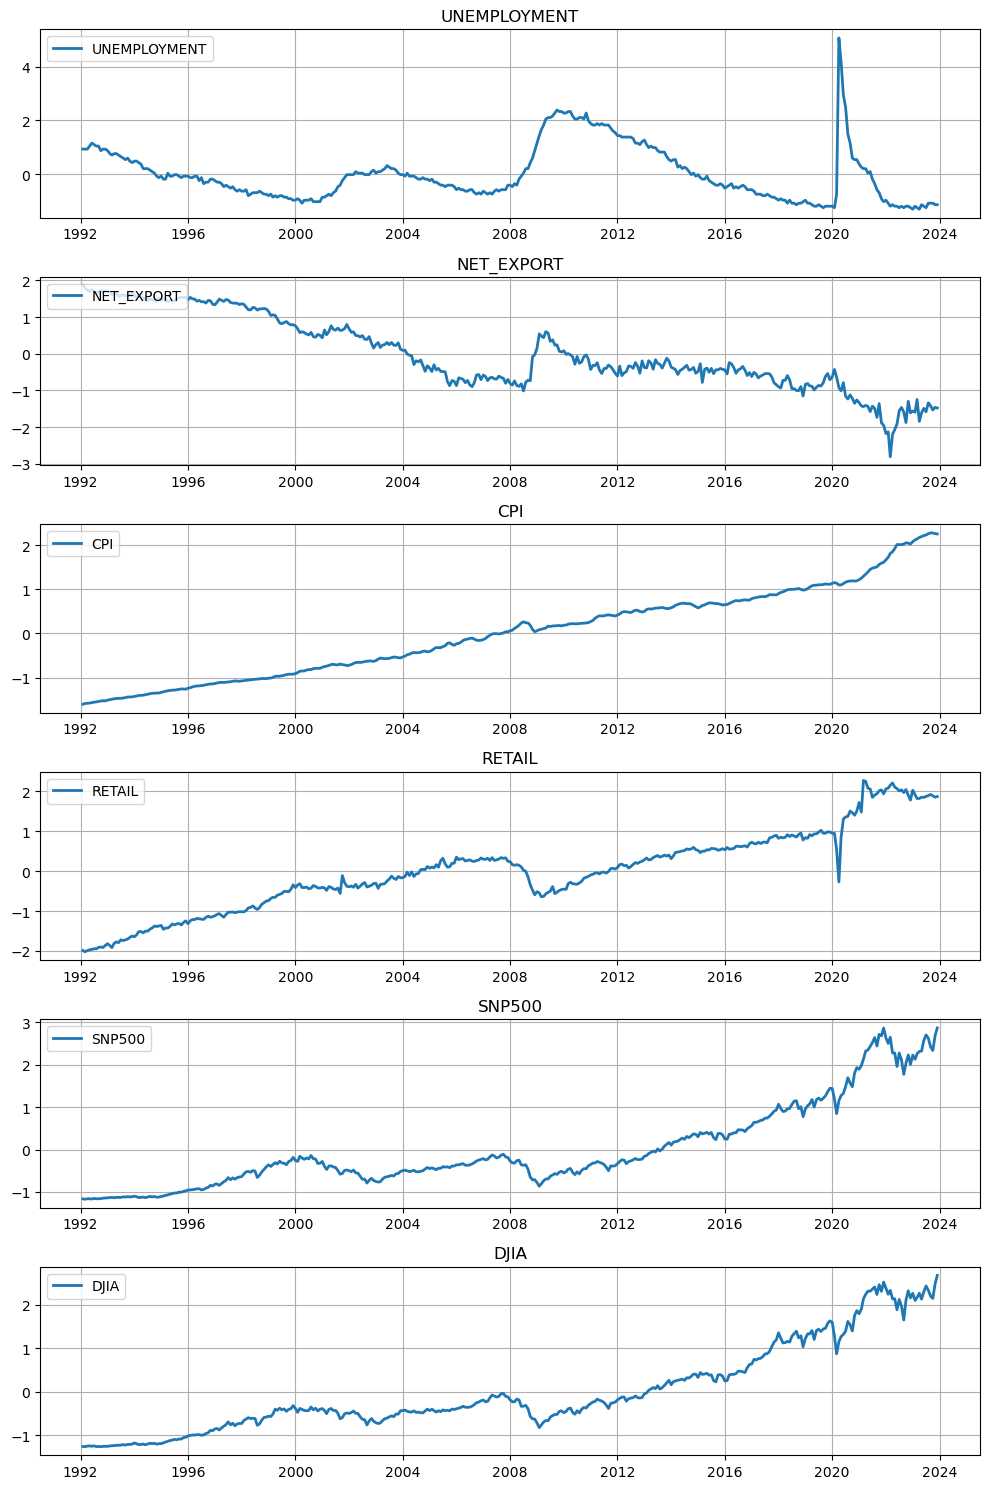

In [151]:
merged_data = pd.read_csv(PATH + 'merged_data.csv', index_col='DATE', parse_dates=True)

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15), dpi=100)
columns = merged_data.columns

for i, ax in enumerate(axes.flatten()):
    ax.plot(merged_data.index, merged_data[columns[i]], label=columns[i], linewidth=2)
    ax.set_title(columns[i])
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()

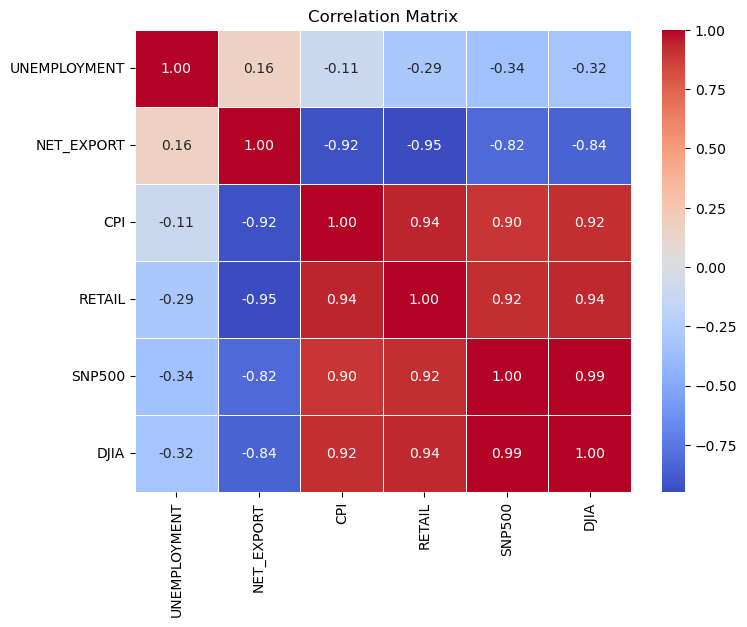

In [152]:
correlation_matrix = merged_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

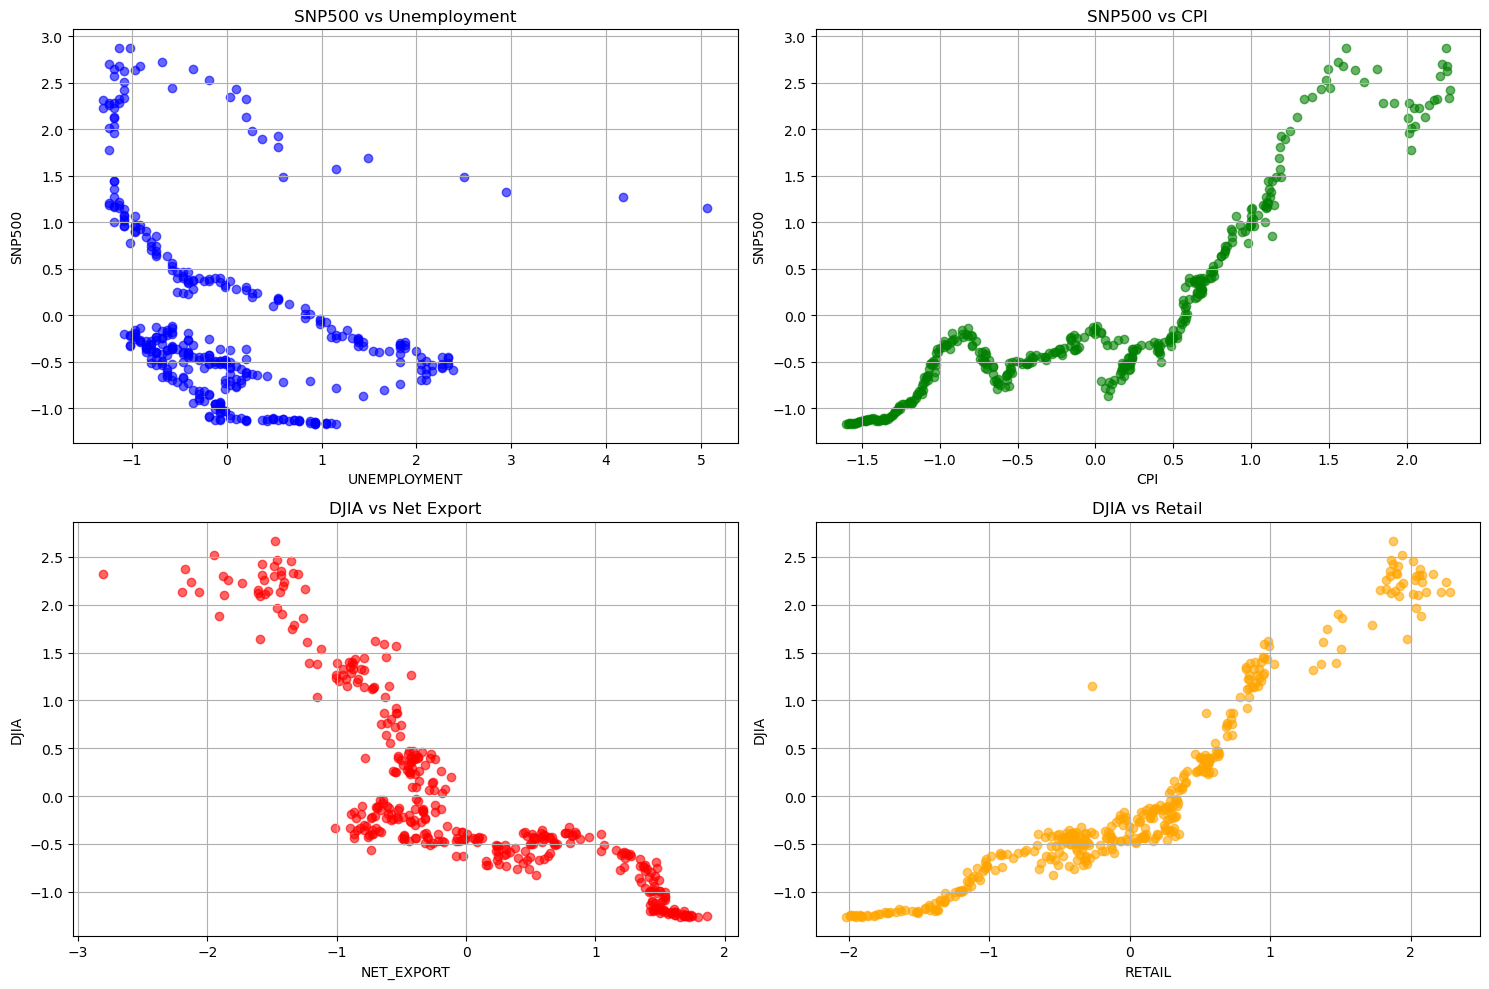

In [153]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# SNP500 vs макроэкономические показатели
axes[0, 0].scatter(merged_data['UNEMPLOYMENT'], merged_data['SNP500'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('UNEMPLOYMENT')
axes[0, 0].set_ylabel('SNP500')
axes[0, 0].set_title('SNP500 vs Unemployment')
axes[0, 0].grid(True)

axes[0, 1].scatter(merged_data['CPI'], merged_data['SNP500'], alpha=0.6, color='green')
axes[0, 1].set_xlabel('CPI')
axes[0, 1].set_ylabel('SNP500')
axes[0, 1].set_title('SNP500 vs CPI')
axes[0, 1].grid(True)

# DJIA vs макроэкономические показатели
axes[1, 0].scatter(merged_data['NET_EXPORT'], merged_data['DJIA'], alpha=0.6, color='red')
axes[1, 0].set_xlabel('NET_EXPORT')
axes[1, 0].set_ylabel('DJIA')
axes[1, 0].set_title('DJIA vs Net Export')
axes[1, 0].grid(True)

axes[1, 1].scatter(merged_data['RETAIL'], merged_data['DJIA'], alpha=0.6, color='orange')
axes[1, 1].set_xlabel('RETAIL')
axes[1, 1].set_ylabel('DJIA')
axes[1, 1].set_title('DJIA vs Retail')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


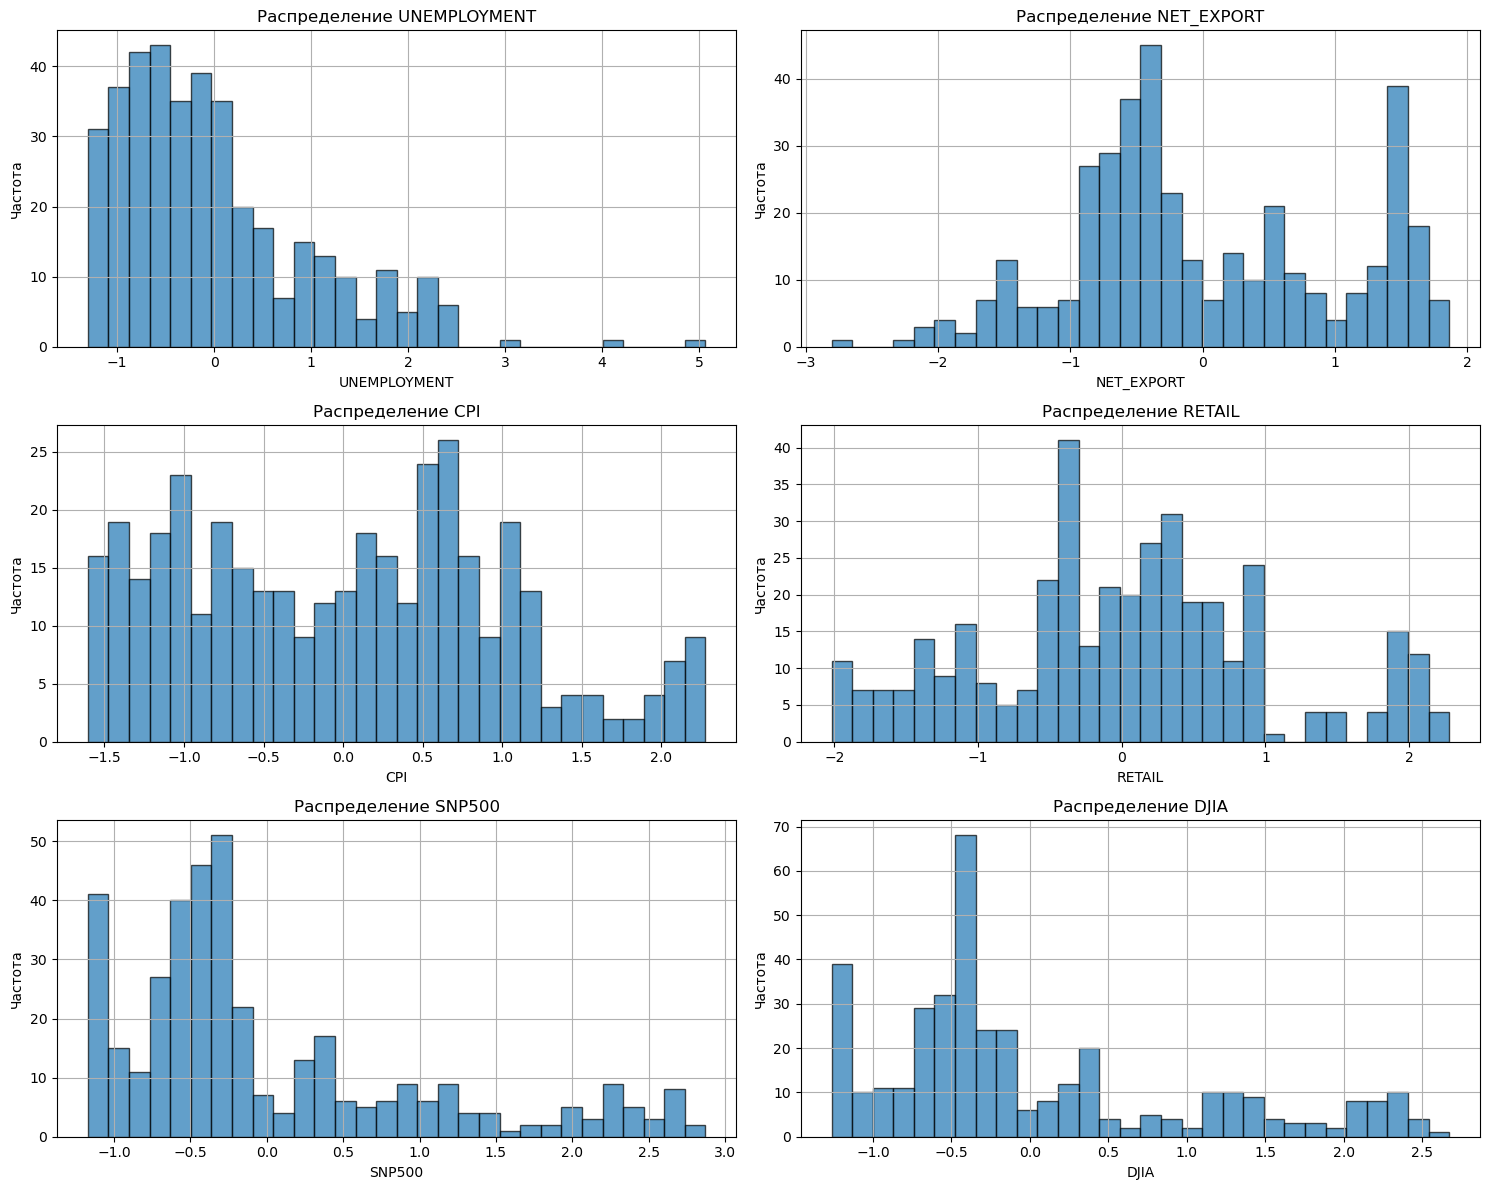

In [154]:

# Анализ распределений
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

variables = ['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL', 'SNP500', 'DJIA']

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    axes[row, col].hist(merged_data[var], bins=30, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'Распределение {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Частота')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [155]:
def adf_test(series, title=''):
    print(f'Критерий Дики-Фуллера: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF статистика', 'p-значение', 'число лага', 'число наблюдений']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'критическое значение ({key})'] = val
    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные основания против нулевой гипотезы")
        print("Нулевая гипотеза отвергается")
        print("Данные не содержат единичного корня и стационарны")
    else:
        print("Слабые основания против нулевой гипотезы")
        print("Нулевая гипотеза не отвергается")
        print("Данные содержат единичный корень и нестационарны")
    print('\n')

adf_test(merged_data['UNEMPLOYMENT'], 'Безработица')
adf_test(merged_data['NET_EXPORT'], 'Чистый экспорт')
adf_test(merged_data['CPI'], 'Индекс потребительских цен')
adf_test(merged_data['RETAIL'], 'Индекс розничной торговли')
adf_test(merged_data['SNP500'], 'S&P 500')
adf_test(merged_data['DJIA'], 'DJIA')

max_lags = 12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Проверка причинности Грейнджера для всех возможных комбинаций временных рядов.
    Строки — откликаемая переменная, столбцы — предикторы. Значения в таблице —
    p-значения. Если p-значение меньше уровня значимости (0.05), это означает,
    что нулевая гипотеза о том, что коэффициенты соответствующих прошлых значений равны нулю,
    отвергается — то есть X влияет на Y."""

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=max_lags, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(max_lags)]
            if verbose:
                print(f'Y = {r}, X = {c}, P-значения = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(merged_data, variables=merged_data.columns[1:])

Критерий Дики-Фуллера: Безработица
ADF статистика                 -3.197242
p-значение                      0.020145
число лага                      0.000000
число наблюдений              382.000000
критическое значение (1%)      -3.447585
критическое значение (5%)      -2.869136
критическое значение (10%)     -2.570816
Сильные основания против нулевой гипотезы
Нулевая гипотеза отвергается
Данные не содержат единичного корня и стационарны


Критерий Дики-Фуллера: Чистый экспорт
ADF статистика                 -1.146153
p-значение                      0.696320
число лага                     12.000000
число наблюдений              370.000000
критическое значение (1%)      -3.448148
критическое значение (5%)      -2.869383
критическое значение (10%)     -2.570948
Слабые основания против нулевой гипотезы
Нулевая гипотеза не отвергается
Данные содержат единичный корень и нестационарны


Критерий Дики-Фуллера: Индекс потребительских цен
ADF статистика                  1.150485
p-значение     

,NET_EXPORT_x,CPI_x,RETAIL_x,SNP500_x,DJIA_x
NET_EXPORT_y,1.0000,0.0091,0.000,0.0000,0.0
CPI_y,0.0016,1.0000,0.000,0.0000,0.0
RETAIL_y,0.0001,0.0162,1.000,0.0000,0.0
SNP500_y,0.0000,0.0007,0.002,1.0000,0.0
DJIA_y,0.0000,0.0016,0.000,0.0017,1.0


#### **Linear Regression**

In [170]:
features = ['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL']
targets = ['SNP500', 'DJIA']

# Разделение данных
train_data, test_data = train_test_split(merged_data, test_size=0.2, shuffle=False)

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data[features])
X_test_scaled = scaler.transform(test_data[features])

models = {}
predictions = {}
metrics = {}

for target in targets:
    # Обучение модели
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, train_data[target])
    models[target] = lr_model
    
    # Предсказания
    train_pred = lr_model.predict(X_train_scaled)
    test_pred = lr_model.predict(X_test_scaled)
    predictions[target] = {'train': train_pred, 'test': test_pred}
    
    # Метрики качества
    train_mae = mean_absolute_error(train_data[target], train_pred)
    test_mae = mean_absolute_error(test_data[target], test_pred)
    train_mse = mean_squared_error(train_data[target], train_pred)
    test_mse = mean_squared_error(test_data[target], test_pred)
    train_r2 = r2_score(train_data[target], train_pred)
    test_r2 = r2_score(test_data[target], test_pred)
    
    metrics[target] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f'\n=== {target} Linear Regression Results ===')
    print(f'Train - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, R²: {train_r2:.4f}')
    print(f'Test  - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, R²: {test_r2:.4f}')
    print(f'Overfitting indicator (Test R² / Train R²): {test_r2/train_r2:.4f}')




=== SNP500 Linear Regression Results ===
Train - MAE: 0.0969, MSE: 0.0147, R²: 0.9287
Test  - MAE: 0.8566, MSE: 0.9982, R²: -1.2596
Overfitting indicator (Test R² / Train R²): -1.3563

=== DJIA Linear Regression Results ===
Train - MAE: 0.0832, MSE: 0.0113, R²: 0.9537
Test  - MAE: 0.7747, MSE: 0.7138, R²: -1.8621
Overfitting indicator (Test R² / Train R²): -1.9525


In [172]:
rf_metrics = {}
rf_predictions = {}

for target in targets:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(train_data[features], train_data[target])
    
    train_pred_rf = rf_model.predict(train_data[features])
    test_pred_rf = rf_model.predict(test_data[features])
    rf_predictions[target] = {'train': train_pred_rf, 'test': test_pred_rf}
    
    train_mae_rf = mean_absolute_error(train_data[target], train_pred_rf)
    test_mae_rf = mean_absolute_error(test_data[target], test_pred_rf)
    train_mse_rf = mean_squared_error(train_data[target], train_pred_rf)
    test_mse_rf = mean_squared_error(test_data[target], test_pred_rf)
    train_r2_rf = r2_score(train_data[target], train_pred_rf)
    test_r2_rf = r2_score(test_data[target], test_pred_rf)
    
    rf_metrics[target] = {
        'train_mae': train_mae_rf,
        'test_mae': test_mae_rf,
        'train_mse': train_mse_rf,
        'test_mse': test_mse_rf,
        'train_r2': train_r2_rf,
        'test_r2': test_r2_rf
    }
    
    print(f'\n{target} Random Forest Results')
    print(f'Train - MAE: {train_mae_rf:.4f}, MSE: {train_mse_rf:.4f}, R²: {train_r2_rf:.4f}')
    print(f'Test  - MAE: {test_mae_rf:.4f}, MSE: {test_mse_rf:.4f}, R²: {test_r2_rf:.4f}')



SNP500 Random Forest Results
Train - MAE: 0.0129, MSE: 0.0003, R²: 0.9985
Test  - MAE: 1.0815, MSE: 1.6249, R²: -2.6784

DJIA Random Forest Results
Train - MAE: 0.0133, MSE: 0.0003, R²: 0.9986
Test  - MAE: 1.0030, MSE: 1.2871, R²: -4.1610


### CatBoost && LightGBM

In [173]:
gb_models = {}
gb_metrics = {}
gb_predictions = {}

# LightGBM
for target in targets:
    lgbm_model = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1)
    lgbm_model.fit(train_data[features], train_data[target])
    
    train_pred_lgbm = lgbm_model.predict(train_data[features])
    test_pred_lgbm = lgbm_model.predict(test_data[features])
    
    train_mae_lgbm = mean_absolute_error(train_data[target], train_pred_lgbm)
    test_mae_lgbm = mean_absolute_error(test_data[target], test_pred_lgbm)
    train_mse_lgbm = mean_squared_error(train_data[target], train_pred_lgbm)
    test_mse_lgbm = mean_squared_error(test_data[target], test_pred_lgbm)
    train_r2_lgbm = r2_score(train_data[target], train_pred_lgbm)
    test_r2_lgbm = r2_score(test_data[target], test_pred_lgbm)
    
    gb_models[f'{target}_lgbm'] = lgbm_model
    gb_metrics[f'{target}_lgbm'] = {
        'train_mae': train_mae_lgbm,
        'test_mae': test_mae_lgbm,
        'train_mse': train_mse_lgbm,
        'test_mse': test_mse_lgbm,
        'train_r2': train_r2_lgbm,
        'test_r2': test_r2_lgbm
    }
    gb_predictions[f'{target}_lgbm'] = {'train': train_pred_lgbm, 'test': test_pred_lgbm}
    
    print(f'{target} LightGBM Results')
    print(f'Train - MAE: {train_mae_lgbm:.4f}, MSE: {train_mse_lgbm:.4f}, R²: {train_r2_lgbm:.4f}')
    print(f'Test  - MAE: {test_mae_lgbm:.4f}, MSE: {test_mse_lgbm:.4f}, R²: {test_r2_lgbm:.4f}')

# CatBoost
for target in targets:
    cb_model = CatBoostRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=False)
    cb_model.fit(train_data[features], train_data[target])
    
    train_pred_cb = cb_model.predict(train_data[features])
    test_pred_cb = cb_model.predict(test_data[features])
    
    train_mae_cb = mean_absolute_error(train_data[target], train_pred_cb)
    test_mae_cb = mean_absolute_error(test_data[target], test_pred_cb)
    train_mse_cb = mean_squared_error(train_data[target], train_pred_cb)
    test_mse_cb = mean_squared_error(test_data[target], test_pred_cb)
    train_r2_cb = r2_score(train_data[target], train_pred_cb)
    test_r2_cb = r2_score(test_data[target], test_pred_cb)
    
    gb_models[f'{target}_catboost'] = cb_model
    gb_metrics[f'{target}_catboost'] = {
        'train_mae': train_mae_cb,
        'test_mae': test_mae_cb,
        'train_mse': train_mse_cb,
        'test_mse': test_mse_cb,
        'train_r2': train_r2_cb,
        'test_r2': test_r2_cb
    }
    gb_predictions[f'{target}_catboost'] = {'train': train_pred_cb, 'test': test_pred_cb}
    
    print(f'{target} CatBoost Results')
    print(f'Train - MAE: {train_mae_cb:.4f}, MSE: {train_mse_cb:.4f}, R²: {train_r2_cb:.4f}')
    print(f'Test  - MAE: {test_mae_cb:.4f}, MSE: {test_mse_cb:.4f}, R²: {test_r2_cb:.4f}')

SNP500 LightGBM Results
Train - MAE: 0.0261, MSE: 0.0012, R²: 0.9943
Test  - MAE: 1.1641, MSE: 1.8198, R²: -3.1198
DJIA LightGBM Results
Train - MAE: 0.0263, MSE: 0.0013, R²: 0.9946
Test  - MAE: 1.1091, MSE: 1.4975, R²: -5.0049
SNP500 CatBoost Results
Train - MAE: 0.0283, MSE: 0.0014, R²: 0.9934
Test  - MAE: 1.3328, MSE: 2.2497, R²: -4.0929
DJIA CatBoost Results
Train - MAE: 0.0290, MSE: 0.0015, R²: 0.9940
Test  - MAE: 1.1930, MSE: 1.7003, R²: -5.8182



Анализ структурных сдвигов:
Статистики обучающей выборки:
       UNEMPLOYMENT  NET_EXPORT         CPI      RETAIL      SNP500  \
count    306.000000  306.000000  306.000000  306.000000  306.000000   
mean       0.147487    0.308974   -0.358622   -0.357945   -0.433496   
std        0.890651    0.849904    0.746832    0.733062    0.454357   
min       -1.077980   -1.010926   -1.604118   -2.019933   -1.171646   
25%       -0.561269   -0.432916   -1.043166   -0.917850   -0.711670   
50%       -0.072488    0.110496   -0.413385   -0.306804   -0.448162   
75%        0.653701    1.233000    0.330594    0.264155   -0.230502   
max        2.385382    1.864187    0.835967    0.732547    0.742072   

             DJIA  
count  306.000000  
mean    -0.435993  
std      0.494131  
min     -1.264169  
25%     -0.724004  
50%     -0.437439  
75%     -0.188448  
max      0.867031  

Статистики тестовой выборки:
       UNEMPLOYMENT  NET_EXPORT        CPI     RETAIL     SNP500       DJIA
count     77.00

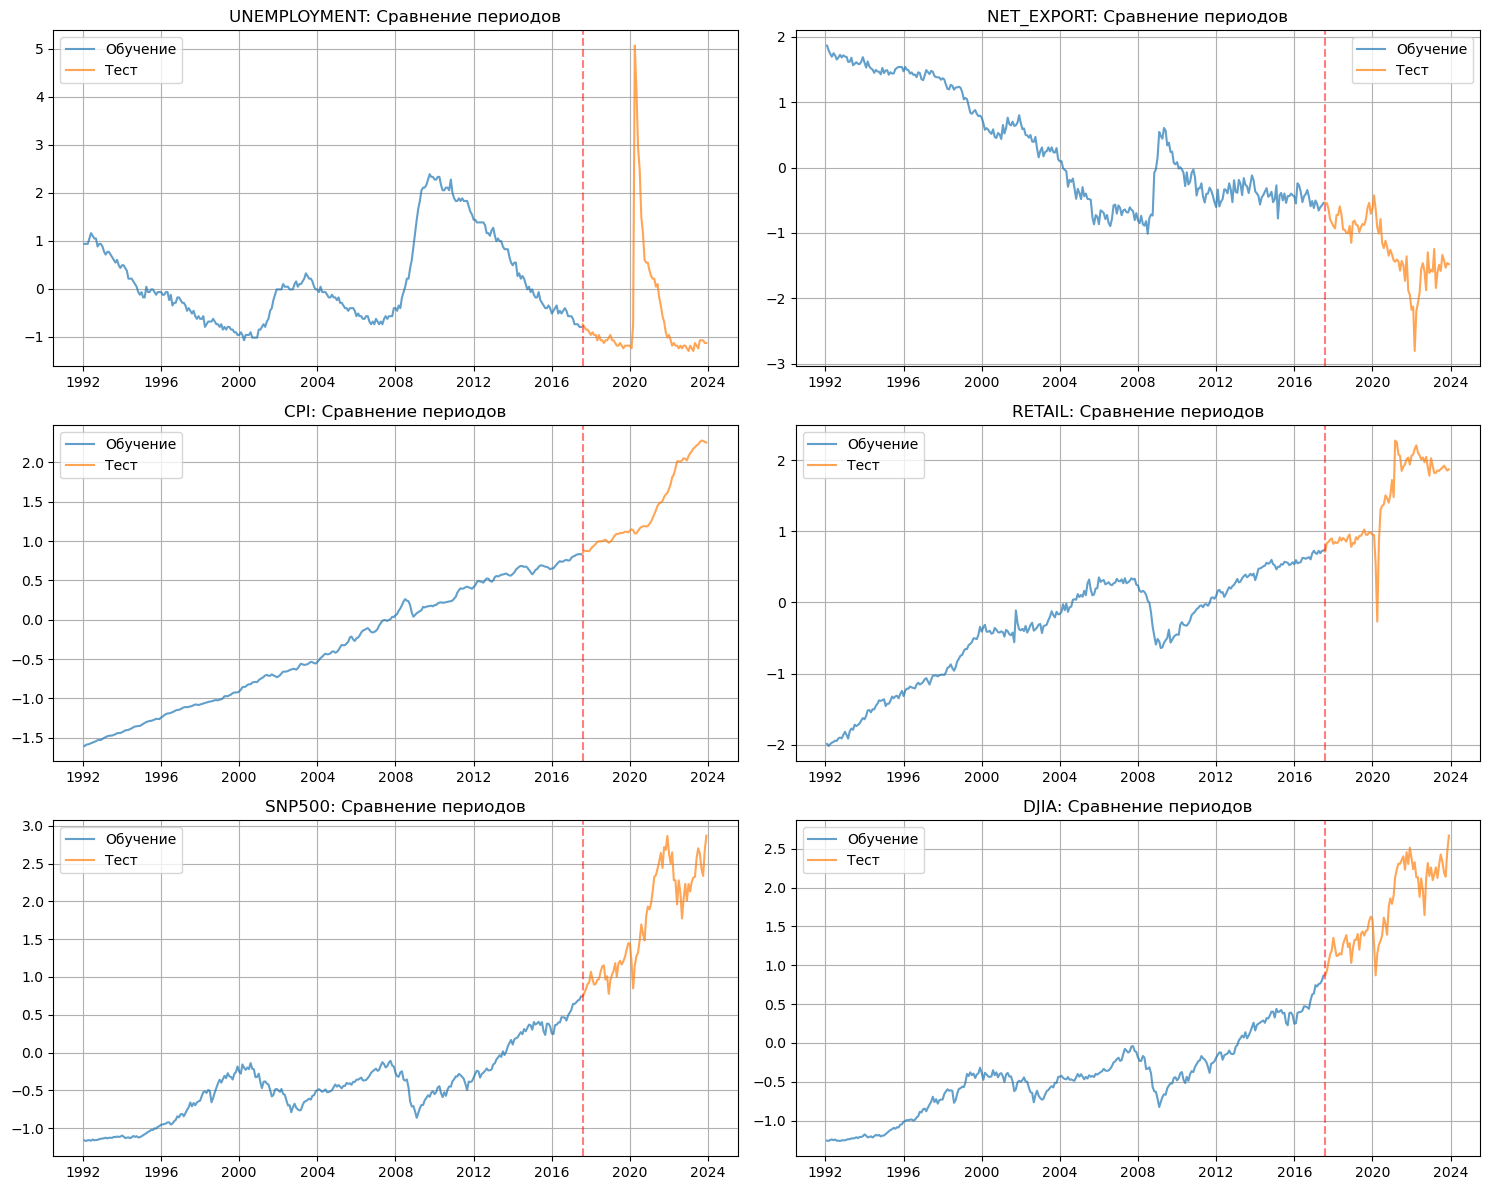

In [ ]:
print("\nАнализ структурных сдвигов:")
print("Статистики обучающей выборки:")
print(train_data[features + targets].describe())
print("\nСтатистики тестовой выборки:")
print(test_data[features + targets].describe())

# Визуализация различий между периодами
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

all_vars = features + targets
for i, var in enumerate(all_vars):
    row = i // 2
    col = i % 2
    
    axes[row, col].plot(train_data.index, train_data[var], label='Обучение', alpha=0.7)
    axes[row, col].plot(test_data.index, test_data[var], label='Тест', alpha=0.7)
    axes[row, col].axvline(x=test_data.index[0], color='red', linestyle='--', alpha=0.5)
    axes[row, col].set_title(f'{var}: Сравнение периодов')
    axes[row, col].legend()
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

**SNP500 case:**

Проведение базового PACF-анализа для определения параметров p, d, q модели ARIMA для заданного набора данных.

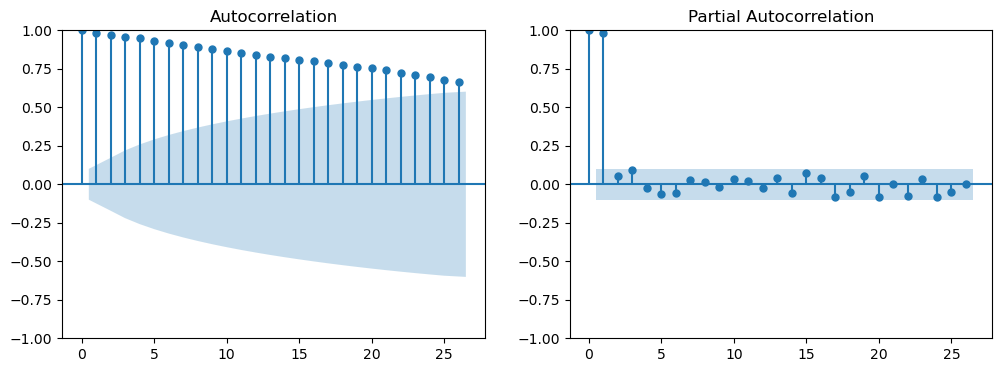

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(merged_data['SNP500'], ax=ax[0])
plot_pacf(merged_data['SNP500'], ax=ax[1])
plt.show()

In [174]:
def fit_arima(data, order, exogenous, target):
    model = ARIMA(data[target], order=order, exog=exogenous)
    fitted_model = model.fit()
    return fitted_model

# ARIMA для SNP500
train_size = int(len(merged_data['SNP500']) * 0.8)
test_size = len(merged_data['SNP500']) - train_size

train_data_arima, test_data_arima = merged_data.iloc[:train_size], merged_data.iloc[train_size:]

p, d, q = 1, 1, 1
exog_train = train_data_arima[features]
exog_test = test_data_arima[features]

In [165]:
train_size = int(len(merged_data['SNP500']) * 0.8)
test_size = len(merged_data['SNP500']) - train_size

train_data, test_data = merged_data.iloc[:train_size], merged_data.iloc[train_size:]

p, d, q = 1, 1, 1
exog_train = train_data[['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL']]
exog_test = test_data[['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL']]
target_col = 'SNP500'

fitted_model = fit_arima(train_data, (p, d, q), exog_train, target_col)

predictions = fitted_model.get_forecast(steps=test_size, exog=exog_test)
predicted_values = predictions.predicted_mean
conf_int = predictions.conf_int()

rmse = np.sqrt(mean_squared_error(test_data[target_col], predicted_values))

arima_r2_snp = r2_score(test_data[target_col], predicted_values)
mae_arima_snp = mean_absolute_error(test_data[target_col], predicted_values)
mse_arima_snp = mean_squared_error(test_data[target_col], predicted_values)

print(f'SNP500 ARIMA R² Score: {arima_r2_snp:.4f}')
print(f'SNP500 ARIMA RMSE: {rmse:.4f}')
print(f'SNP500 ARIMA MAE: {mae_arima_snp:.4f}')
print(f'SNP500 ARIMA MSE: {mse_arima_snp:.4f}')

c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SNP500 ARIMA R² Score: -0.8825
SNP500 ARIMA RMSE: 0.9119
SNP500 ARIMA MAE: 0.7598
SNP500 ARIMA MSE: 0.8316


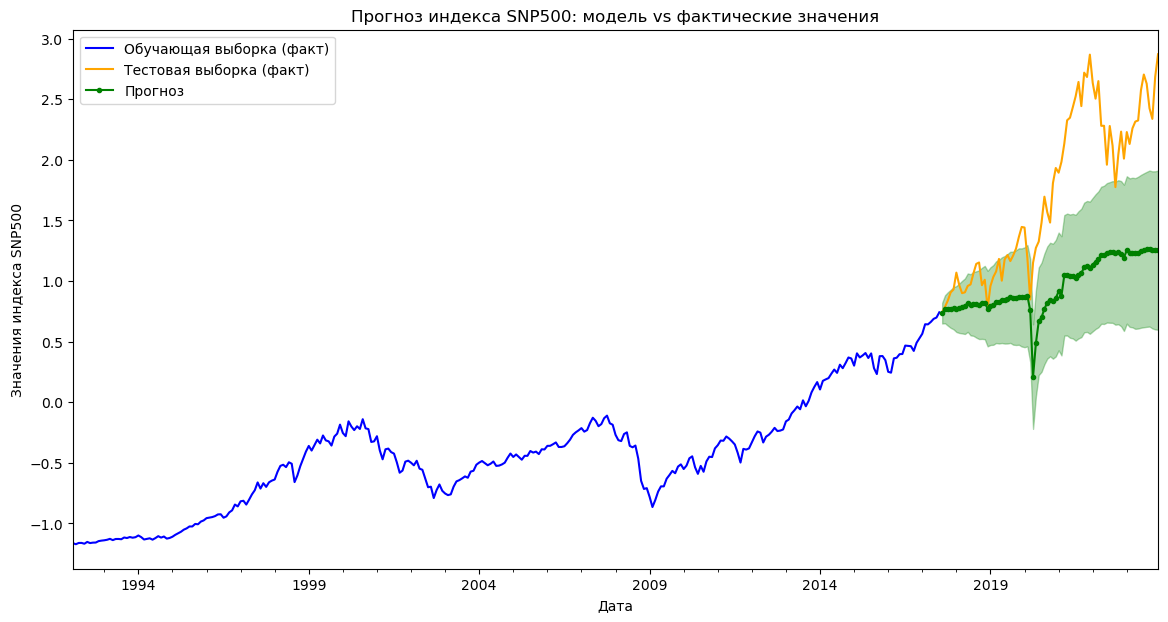

In [166]:
conf_int = conf_int.astype(float)

fig, ax = plt.subplots(figsize=(14, 7))

train_data[target_col].plot(ax=ax, label='Обучающая выборка (факт)', color='blue')
test_data[target_col].plot(ax=ax, label='Тестовая выборка (факт)', color='orange')

predicted_values.plot(ax=ax, label='Прогноз', color='green', style='.-')

ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3)

ax.set_title('Прогноз индекса SNP500: модель vs фактические значения')
ax.set_xlabel('Дата')
ax.set_ylabel('Значения индекса SNP500')
ax.legend()

plt.show()

**DJIA case:**

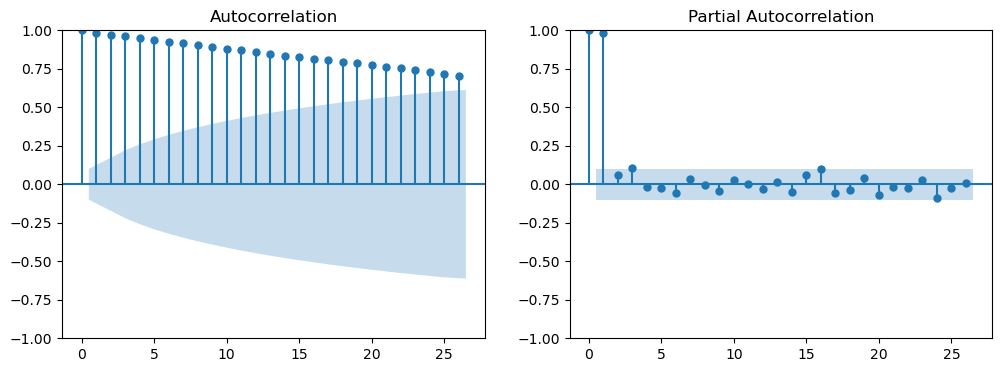

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(merged_data['DJIA'], ax=ax[0])
plot_pacf(merged_data['DJIA'], ax=ax[1])
plt.show()

In [168]:
train_size = int(len(merged_data['DJIA']) * 0.8)
test_size = len(merged_data['DJIA']) - train_size

train_data, test_data = merged_data.iloc[:train_size], merged_data.iloc[train_size:]

p, d, q = 1, 1, 1
exog_train = train_data[['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL']]
exog_test = test_data[['UNEMPLOYMENT', 'NET_EXPORT', 'CPI', 'RETAIL']]
target_col = 'DJIA'

fitted_model = fit_arima(train_data, (p, d, q), exog_train, target_col)

predictions = fitted_model.get_forecast(steps=test_size, exog=exog_test)
predicted_values = predictions.predicted_mean
conf_int = predictions.conf_int()

rmse = np.sqrt(mean_squared_error(test_data[target_col], predicted_values))

arima_r2_djia = r2_score(test_data[target_col], predicted_values)
mae_arima_djia = mean_absolute_error(test_data[target_col], predicted_values)
mse_arima_djia = mean_squared_error(test_data[target_col], predicted_values)

print(f'DJIA ARIMA R² Score: {arima_r2_djia:.4f}')
print(f'DJIA ARIMA RMSE: {rmse:.4f}')
print(f'DJIA ARIMA MAE: {mae_arima_djia:.4f}')
print(f'DJIA ARIMA MSE: {mse_arima_djia:.4f}')

c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


DJIA ARIMA R² Score: -1.3620
DJIA ARIMA RMSE: 0.7675
DJIA ARIMA MAE: 0.6811
DJIA ARIMA MSE: 0.5890


c:\Users\evoni\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


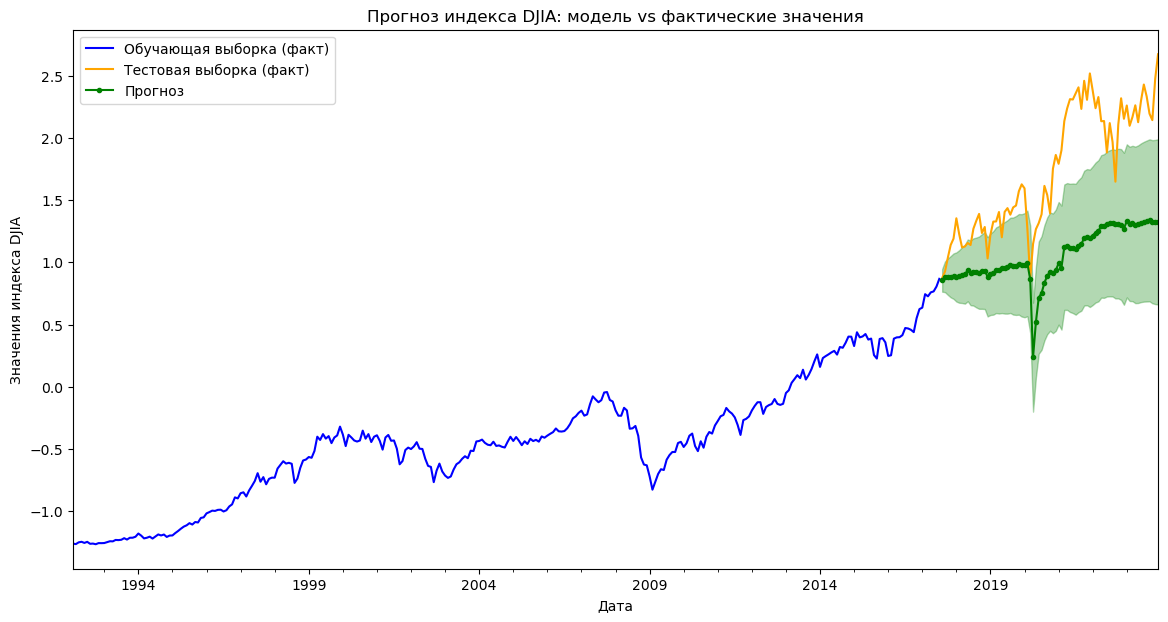

In [169]:
conf_int = conf_int.astype(float)

fig, ax = plt.subplots(figsize=(14, 7))

train_data[target_col].plot(ax=ax, label='Обучающая выборка (факт)', color='blue')
test_data[target_col].plot(ax=ax, label='Тестовая выборка (факт)', color='orange')

predicted_values.plot(ax=ax, label='Прогноз', color='green', style='.-')

ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3)

ax.set_title('Прогноз индекса DJIA: модель vs фактические значения')
ax.set_xlabel('Дата')
ax.set_ylabel('Значения индекса DJIA')
ax.legend()

plt.show()